# Molmo Point Visualizer

This notebook visualizes points from Molmo model output on original images. It parses XML-like tags with percentage coordinates and overlays them as labeled points on images, saving the results to the `visuals/` directory.

## Example Input Format:
```xml
<points x1="12.1" y1="23.4" x2="45.0" y2="67.2" x3="78.8" y3="11.9" x4="102.5" y4="53.0" alt="voltage.battery">voltage.battery</points>
```

Where `x1`, `y1` etc. represent percentage coordinates on the image.

## 1. Import Required Libraries

In [48]:
import re
import os
from pathlib import Path
from typing import List, Tuple
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Create visuals directory if it doesn't exist
visuals_dir = Path("visuals")
visuals_dir.mkdir(exist_ok=True)

print("Libraries imported successfully!")
print(f"Visuals directory: {visuals_dir.absolute()}")

Libraries imported successfully!
Visuals directory: /auto/brno2/home/nademvit/vthesis/Molmo-7B-D/visuals


## 2. Define Function to Parse Molmo Points

This function extracts coordinates and labels from the Molmo XML-like format.

In [49]:
def parse_molmo_points(response_text: str) -> List[Tuple[str, List[Tuple[float, float]]]]:
    """
    Parse Molmo model response and extract point coordinates with labels.
    
    Args:
        response_text: Raw response text from Molmo model
        
    Returns:
        List of tuples containing (label, list_of_percentage_coordinates)
    """
    # Find all <points> tags
    point_pattern = r'<points\s+([^>]+)\s+alt="([^"]+)">([^<]+)</points>'
    matches = re.findall(point_pattern, response_text)
    
    results = []
    
    for attributes, label, content in matches:
        # Extract coordinates from attributes
        coord_pattern = r'x(\d+)="([^"]+)"\s+y\1="([^"]+)"'
        coord_matches = re.findall(coord_pattern, attributes)
        
        coordinates = []
        for _, x, y in coord_matches:
            coordinates.append((float(x), float(y)))
        
        results.append((label, coordinates))
    
    return results

def convert_percentage_to_pixels(coordinates: List[Tuple[float, float]], 
                                image_width: int, image_height: int) -> List[Tuple[int, int]]:
    """
    Convert percentage coordinates to pixel coordinates.
    
    Args:
        coordinates: List of (x_percent, y_percent) tuples
        image_width: Image width in pixels
        image_height: Image height in pixels
        
    Returns:
        List of (x_pixel, y_pixel) tuples
    """
    pixel_coords = []
    for x_percent, y_percent in coordinates:
        x_pixel = int(x_percent * image_width / 100.0)
        y_pixel = int(y_percent * image_height / 100.0)
        pixel_coords.append((x_pixel, y_pixel))
    
    return pixel_coords

# Test the parsing function
test_response = '''<points x1="12.1" y1="23.4" x2="45.0" y2="67.2" x3="78.8" y3="11.9" x4="102.5" y4="53.0" alt="voltage.battery">voltage.battery</points>'''

parsed = parse_molmo_points(test_response)
print("Parsed points:", parsed)

Parsed points: [('voltage.battery', [(12.1, 23.4), (45.0, 67.2), (78.8, 11.9), (102.5, 53.0)])]


## 3. Load Image and Parse Points

Load the target image and parse the Molmo points string to extract coordinates and labels.

In [ ]:
# Example configuration - modify these as needed
image_path = "data/images/diagram.png"  # Path to your image
molmo_response = '''<points x1="46.0" y1="53.0" alt="voltage.battery">voltage.battery</points>'''

# Load the image
try:
    image = Image.open(image_path)
    image_width, image_height = image.size
    print(f"Image loaded successfully: {image_width}x{image_height}")
    
    # Parse the Molmo points
    parsed_points = parse_molmo_points(molmo_response)
    print(f"Found {len(parsed_points)} point groups")
    
    for label, coords in parsed_points:
        print(f"Label: {label}, Points: {len(coords)}")
        pixel_coords = convert_percentage_to_pixels(coords, image_width, image_height)
        print(f"  Percentage coords: {coords}")
        print(f"  Pixel coords: {pixel_coords}")
        
except FileNotFoundError:
    print(f"Image file not found: {image_path}")
    print("Please update the image_path variable to point to your image file")
except Exception as e:
    print(f"Error loading image: {e}")

Image loaded successfully: 936x492
Found 1 point groups
Label: resistor, Points: 1
  Percentage coords: [(56.6, 24.4)]
  Pixel coords: [(529, 120)]


## 4. Draw Points with Labels on Image

Overlay each point on the image at the correct pixel location with labels.

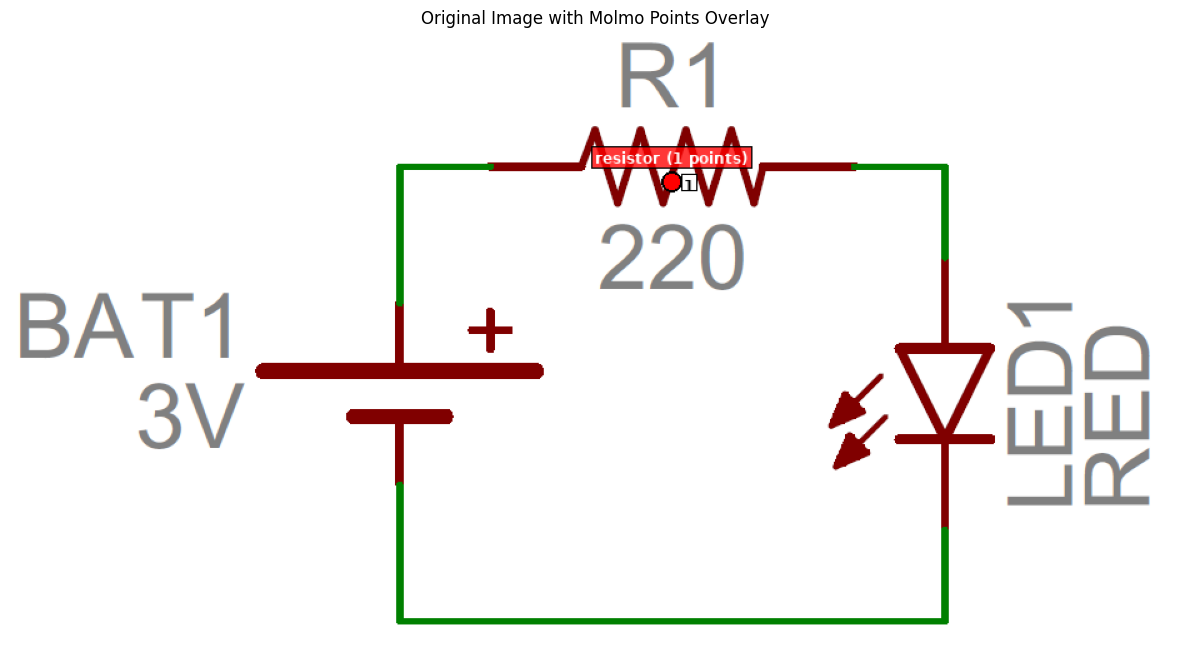

Visualization created successfully!


In [51]:
def visualize_points_on_image(image_path: str, molmo_response: str, 
                             point_size: int = 8, font_size: int = 12) -> Image.Image:
    """
    Create a visualization of the image with points and labels overlaid.
    
    Args:
        image_path: Path to the source image
        molmo_response: Molmo response containing points
        point_size: Size of the points to draw
        font_size: Size of the label text
        
    Returns:
        PIL Image with points and labels overlaid
    """
    # Load image
    image = Image.open(image_path).convert('RGBA')
    image_width, image_height = image.size
    
    # Create a transparent overlay for drawing
    overlay = Image.new('RGBA', image.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    
    # Try to load a font, fall back to default if not available
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", font_size)
    except:
        try:
            font = ImageFont.load_default()
        except:
            font = None
    
    # Parse points
    parsed_points = parse_molmo_points(molmo_response)
    
    # Color palette for different labels
    colors = [
        (255, 0, 0, 255),    # Red
        (0, 255, 0, 255),    # Green
        (0, 0, 255, 255),    # Blue
        (255, 255, 0, 255),  # Yellow
        (255, 0, 255, 255),  # Magenta
        (0, 255, 255, 255),  # Cyan
        (255, 165, 0, 255),  # Orange
        (128, 0, 128, 255),  # Purple
    ]
    
    for i, (label, coords) in enumerate(parsed_points):
        color = colors[i % len(colors)]
        pixel_coords = convert_percentage_to_pixels(coords, image_width, image_height)
        
        for j, (x, y) in enumerate(pixel_coords):
            # Draw point
            draw.ellipse([x-point_size, y-point_size, x+point_size, y+point_size], 
                        fill=color, outline=(0, 0, 0, 255), width=2)
            
            # Draw point number
            point_label = f"{j+1}"
            if font:
                bbox = draw.textbbox((0, 0), point_label, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
            else:
                text_width, text_height = 10, 10
            
            # Draw text background
            text_x = x + point_size + 2
            text_y = y - text_height // 2
            draw.rectangle([text_x-2, text_y-2, text_x+text_width+2, text_y+text_height+2], 
                         fill=(255, 255, 255, 200), outline=(0, 0, 0, 255))
            
            # Draw text
            draw.text((text_x, text_y), point_label, fill=(0, 0, 0, 255), font=font)
        
        # Draw label for the group
        if pixel_coords:
            first_x, first_y = pixel_coords[0]
            label_text = f"{label} ({len(pixel_coords)} points)"
            if font:
                bbox = draw.textbbox((0, 0), label_text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]
            else:
                text_width, text_height = len(label_text) * 6, 12
            
            label_x = first_x - text_width // 2
            label_y = first_y - point_size - text_height - 5
            
            # Ensure label is within image bounds
            label_x = max(5, min(label_x, image_width - text_width - 5))
            label_y = max(5, label_y)
            
            # Draw label background
            draw.rectangle([label_x-3, label_y-2, label_x+text_width+3, label_y+text_height+2], 
                         fill=(*color[:3], 200), outline=(0, 0, 0, 255))
            
            # Draw label text
            draw.text((label_x, label_y), label_text, fill=(255, 255, 255, 255), font=font)
    
    # Combine original image with overlay
    result = Image.alpha_composite(image, overlay)
    return result.convert('RGB')

# Test the visualization function if we have a valid image
try:
    if 'image' in locals():
        result_image = visualize_points_on_image(image_path, molmo_response)
        
        # Display the result
        plt.figure(figsize=(12, 8))
        plt.imshow(result_image)
        plt.axis('off')
        plt.title('Original Image with Molmo Points Overlay')
        plt.tight_layout()
        plt.show()
        
        print("Visualization created successfully!")
    else:
        print("No image loaded - please run the previous cell first")
except Exception as e:
    print(f"Error creating visualization: {e}")

## 5. Save Visualized Image to visuals/ Directory

Save the resulting image with points and labels to the visuals/ directory.

In [52]:
def save_visualized_image(image_path: str, molmo_response: str, output_dir: str = "visuals") -> str:
    """
    Create and save a visualization of the image with Molmo points.
    
    Args:
        image_path: Path to the source image
        molmo_response: Molmo response containing points
        output_dir: Directory to save the result (default: "visuals")
        
    Returns:
        Path to the saved image
    """
    # Create output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Generate output filename
    image_name = Path(image_path).stem
    output_filename = f"{image_name}_with_points.png"
    full_output_path = output_path / output_filename
    
    # Create visualization
    result_image = visualize_points_on_image(image_path, molmo_response)
    
    # Save the image
    result_image.save(full_output_path, 'PNG')
    
    return str(full_output_path)

# Save the visualization if we have a valid image
try:
    if 'image' in locals():
        saved_path = save_visualized_image(image_path, molmo_response)
        print(f"✅ Visualization saved to: {saved_path}")
        print(f"📁 Full path: {Path(saved_path).absolute()}")
        
        # Verify the file was created
        if Path(saved_path).exists():
            file_size = Path(saved_path).stat().st_size
            print(f"📊 File size: {file_size:,} bytes")
        else:
            print("❌ Error: File was not created")
    else:
        print("No image loaded - please run the image loading cell first")
except Exception as e:
    print(f"❌ Error saving image: {e}")

✅ Visualization saved to: visuals/diagram_with_points.png
📁 Full path: /auto/brno2/home/nademvit/vthesis/Molmo-7B-D/visuals/diagram_with_points.png
📊 File size: 25,594 bytes


## 6. Example Usage and Batch Processing

Examples of how to use the functions with different inputs and process multiple images.

In [53]:
# Example 1: Process a single image with custom Molmo response
def process_single_image(image_path: str, molmo_response: str):
    """Process a single image with Molmo points."""
    try:
        saved_path = save_visualized_image(image_path, molmo_response)
        print(f"✅ Processed: {image_path} -> {saved_path}")
        return saved_path
    except Exception as e:
        print(f"❌ Error processing {image_path}: {e}")
        return None

# Example 2: Batch process multiple images
def batch_process_images(image_responses: dict):
    """
    Batch process multiple images with their corresponding Molmo responses.
    
    Args:
        image_responses: Dictionary mapping image paths to Molmo responses
    """
    results = []
    
    for image_path, molmo_response in image_responses.items():
        if Path(image_path).exists():
            result = process_single_image(image_path, molmo_response)
            if result:
                results.append(result)
        else:
            print(f"⚠️  Image not found: {image_path}")
    
    print(f"\n📊 Batch processing complete: {len(results)} images processed")
    return results

# Example usage with different Molmo responses
image_path = "data/images/diagram.png"
# points = '''<points x1="12.1" y1="23.4" x2="45.0" y2="67.2" x3="78.8" y3="11.9" x4="102.5" y4="53.0" alt="voltage.battery">voltage.battery</points>'''
points = '''<points x1="655" y1="241" x2="787" y2="397" alt="diode.light_emitting">diode.light_emitting</points>'''
example_responses = {
    # You can add more image paths and their corresponding Molmo responses here
    image_path: points,
    
    # Example with multiple point groups
    # "path/to/another/image.jpg": '''<points x1="10.0" y1="20.0" x2="30.0" y2="40.0" alt="resistors">resistors</points><points x1="60.0" y1="70.0" alt="capacitor">capacitor</points>''',
}

# Uncomment the line below to run batch processing
# batch_results = batch_process_images(example_responses)

print("Example functions defined successfully!")
print("\nTo use:")
print("1. Update the image_path and molmo_response variables in section 3")
print("2. Run all cells to process your image")
print("3. Check the 'visuals/' directory for the output")
print("\nFor batch processing:")
print("1. Add your image paths and responses to the example_responses dictionary")
print("2. Uncomment and run the batch_process_images call")

Example functions defined successfully!

To use:
1. Update the image_path and molmo_response variables in section 3
2. Run all cells to process your image
3. Check the 'visuals/' directory for the output

For batch processing:
1. Add your image paths and responses to the example_responses dictionary
2. Uncomment and run the batch_process_images call
